#HW1 - Data Exploration and Preparation

In [ ]:
#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


# **Part 1: Date Loading and First Look**

##Q1

In [ ]:
dataset = pd.read_csv(filename)

In [ ]:
dataset.shape

(2500, 28)

##Q2

In [ ]:
dataset['num_of_siblings'].value_counts()

1.0    786
2.0    553
0.0    544
3.0    318
4.0    120
5.0     34
6.0      9
7.0      1
8.0      1
9.0      1
Name: num_of_siblings, dtype: int64

### **Partitioning the Data**

##Q5

In [ ]:
from sklearn.model_selection import train_test_split

#Splitting the data into 'train' and 'test'
train, test = train_test_split(dataset, test_size = 0.2, train_size = 0.8, random_state = 122)

# **Part 2: Warming Up With k-Nearest Neighbors**

### **Basic Data exploration**

##Q6

In [ ]:
#Turning 'risk' into numerical values
train.risk = train.risk.replace({'High': 1, 'Low': 0})

#Calculating correlations
corr_pcr_04 = train.corr().risk.PCR_04
corr_pcr_08 = train.corr().risk.PCR_08
corr_pcr_10 = train.corr().risk.PCR_10

print("Correlations are: pcr_04 - ", corr_pcr_04, " pcr_08 - ", corr_pcr_08, " pcr_10 - ", corr_pcr_10)

Correlations are: pcr_04 -  0.023026580152301208  pcr_08 -  -0.011683685828004397  pcr_10 -  0.09580951519896994


##Q7

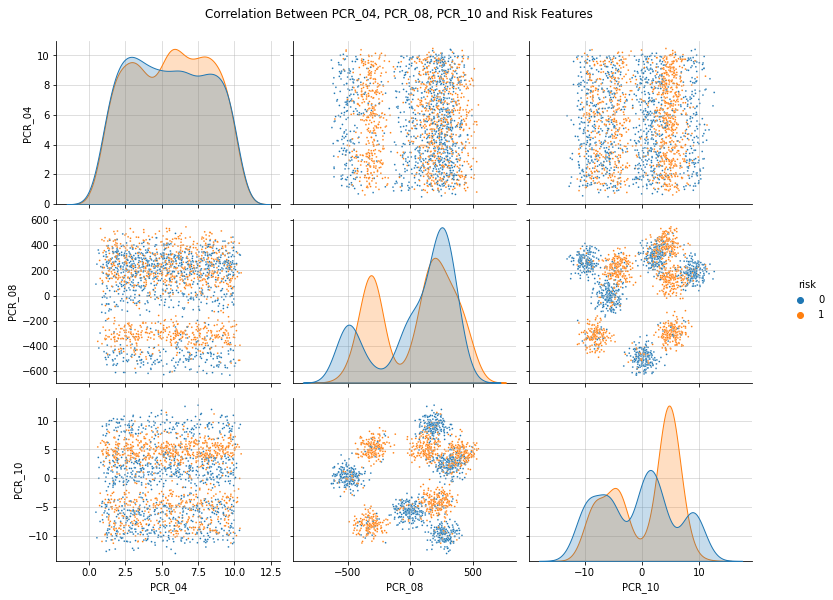

In [ ]:
g=sns.pairplot(train[['PCR_04', 'PCR_08', 'PCR_10', 'risk']], hue = 'risk', plot_kws={"s": 3})
g.fig.suptitle("Correlation Between PCR_04, PCR_08, PCR_10 and Risk Features", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

### **k-NN Implementation**

##Q8

In [ ]:
from numpy.core.fromnumeric import argpartition
from sklearn.base import BaseEstimator,ClassifierMixin
from scipy.spatial import distance

class kNN(BaseEstimator, ClassifierMixin):
 def __init__(self, n_neighbors:int = 5):
   self.n_neighbors = n_neighbors
 
 def fit(self, X, y):
    self.X = X
    self.y = y
    return self
 
 def predict(self, X):
   #Calculating distances between every 2 points, then splicing to get k 
   #smallest distances for each point
   all_distances = distance.cdist(X, self.X, metric = 'euclidean')
   distances_sorted = np.argpartition(all_distances, self.n_neighbors, axis = 1)
   k_nearest_neighbors = distances_sorted[ : , :self.n_neighbors]

   #Creating array of the labels matching k nearest neighbors for each point,
   #and determining a point as having label 1 if more than half the neighbors
   #have a label of 1
   label_array = np.array([self.y[i] for i in k_nearest_neighbors.reshape(len(X) * self.n_neighbors)]).reshape(len(X), self.n_neighbors)
   predictions = label_array.sum(axis = 1)
   boundary = (int)(self.n_neighbors / 2) + 1
   predictions = np.array([1 if x >= boundary else 0 for x in predictions])
   return predictions

In [ ]:
def visualize_clf(clf, X, Y, title, marker_size=150,
                  grid_length=300):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    #plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("PCR_08")
    plt.ylabel("PCR_10")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(range(n_classes), palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

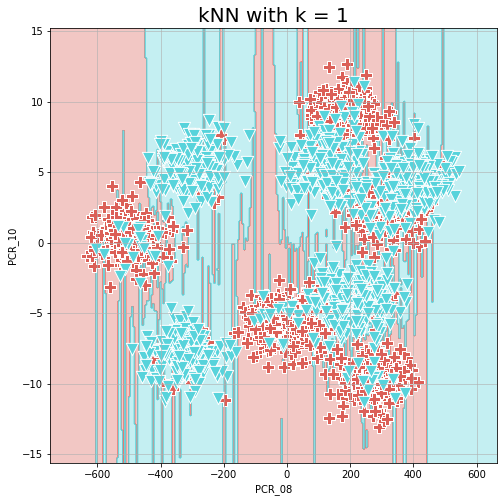

In [ ]:
from copy import copy

#creating temp dataframe
temp_train = copy(train[['PCR_08', 'PCR_10']].values)
temp_labels = copy(train.risk.values)

#Training and visualizing kNN model with k = 1
knn_inst_1 = kNN(1)
knn_inst_1.fit(temp_train, temp_labels)
visualize_clf(knn_inst_1, temp_train, temp_labels, "kNN with k = 1")

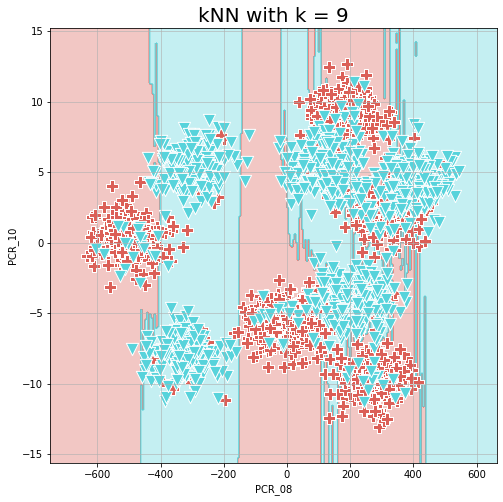

In [ ]:
#Training and visualizing kNN model with k = 9
knn_inst_2 = kNN(9)

knn_inst_2.fit(temp_train, temp_labels)

visualize_clf(knn_inst_2, temp_train, temp_labels, "kNN with k = 9")

In [ ]:
#Calculating accuracy of both models
print("score of k=1 is ", knn_inst_1.score(temp_train, temp_labels), " and score of k=9 is ", knn_inst_2.score(temp_train, temp_labels))

score of k=1 is  1.0  and score of k=9 is  0.827


### **Data Normalization**

##Q9

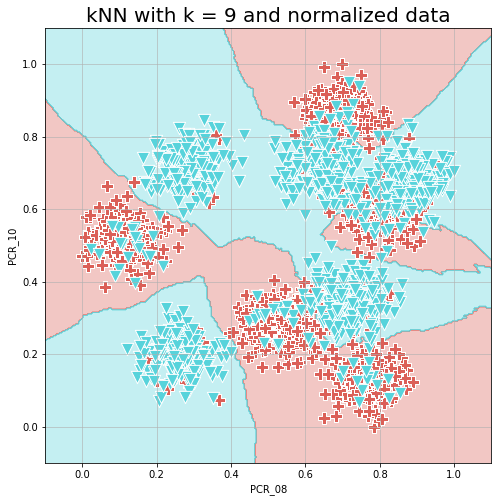

The score of k = 9 with normalized data is  0.865


In [ ]:
#Creating normalized temporary dataframe
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

features = pd.DataFrame(temp_train)
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

temp_train = np.array(features)

#Training new kNN model
knn_inst_3 = kNN(9)
knn_inst_3.fit(temp_train, temp_labels)

visualize_clf(knn_inst_3, temp_train, temp_labels, "kNN with k = 9 and normalized data")
print("The score of k = 9 with normalized data is ", knn_inst_3.score(temp_train, temp_labels))

# **Part 3: Date Exploring**

##Q11

In [ ]:
#Using OHE to turn 'blood type' into numerical features
blood_type_one_hot = pd.get_dummies(train['blood_type'])
train = train.join(blood_type_one_hot)
train.drop('blood_type' , axis = 1 , inplace = True)

##Q12

In [ ]:
#Turning 'symptoms' into numerical features
symptoms_one_hot = train['symptoms'].str.get_dummies(sep=';')
train = train.join(symptoms_one_hot)
train.drop('symptoms' , axis = 1 , inplace = True)

## Q13

In [ ]:
#Turning the rest of the features into numerical features
train['sex'].replace({'F': 1, 'M' :0} , inplace = True)
train['spread'].replace({'High': 1, 'Low' :0}, inplace = True)
train['covid'].replace({True: 1, False: 0}, inplace = True)

In [ ]:
train[["pcr_day", "pcr_month", "pcr_year"]] = train["pcr_date"].str.split("-", expand = True)
train.drop('pcr_date' , axis = 1 , inplace = True)

In [ ]:
train['current_location'] = train['current_location'].str.strip("()'")
train[["current_location_latitude", "current_location_longitude"]] = train["current_location"].str.split("', '", expand = True)
train.drop('current_location' , axis = 1 , inplace = True)

In [ ]:
train.drop('address' , axis = 1 , inplace = True)

##Q14

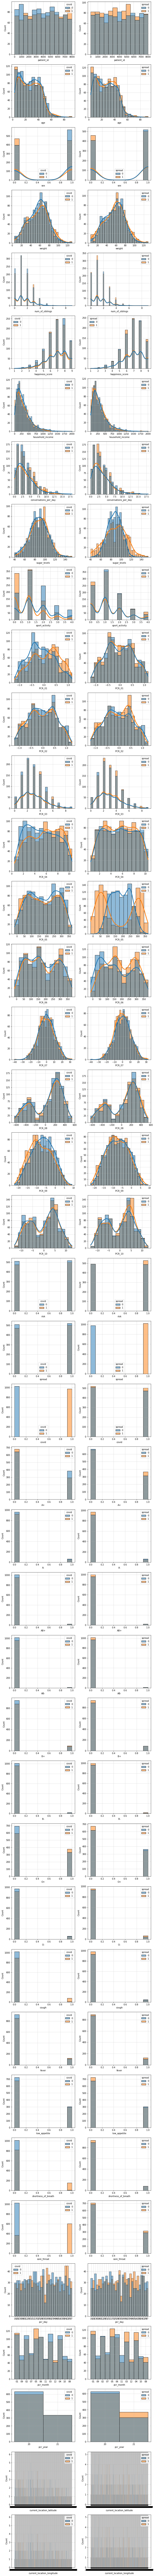

In [ ]:
#Plotting histograms for every feature
COL_NAME = train.columns
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

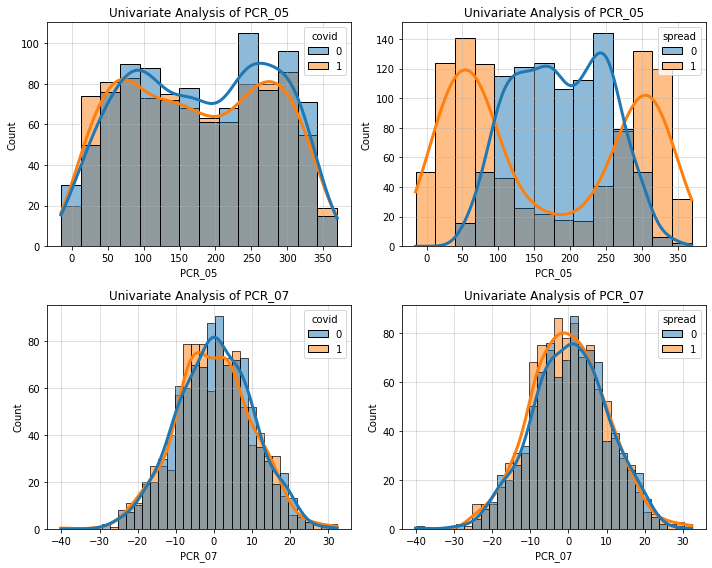

In [ ]:
#Plotting histograms for the 2 requested features
COL_NAME = ['PCR_05', 'PCR_07']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.title(("Univariate Analysis of " + COL_NAME[row]))
 plt.subplot(ROWS,COLS, row * COLS + 2)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.title(("Univariate Analysis of " + COL_NAME[row]))
 plt.grid(alpha=0.5)
plt.tight_layout()


## Q15

In [ ]:
#Calculating correlation between all features and spread
s = train.corr().spread.abs()
s.sort_values(kind="quicksort", ascending=False)

spread                   1.000000
PCR_06                   0.117236
PCR_05                   0.102453
sugar_levels             0.049031
O-                       0.044679
A+                       0.038875
sex                      0.037267
A-                       0.033299
PCR_10                   0.032669
O+                       0.032305
fever                    0.028397
B-                       0.025704
PCR_09                   0.025684
low_appetite             0.022457
cough                    0.021642
PCR_03                   0.021364
age                      0.021107
weight                   0.019948
risk                     0.019692
PCR_07                   0.018319
household_income         0.016748
AB-                      0.015867
PCR_04                   0.014484
PCR_08                   0.012441
conversations_per_day    0.011976
sore_throat              0.011153
covid                    0.010573
B+                       0.010033
PCR_01                   0.009602
sport_activity

## Q16

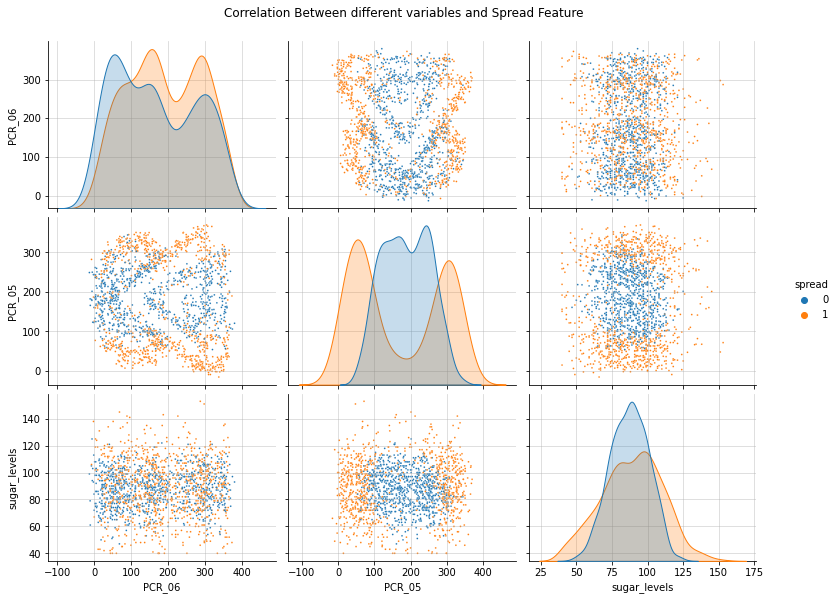

In [ ]:
#Checking correlations between 3 top features and spread
g=sns.pairplot(train[['PCR_06', 'PCR_05', 'sugar_levels', 'spread']], hue = 'spread', plot_kws={"s": 3})
g.fig.suptitle("Correlation Between different variables and Spread Feature", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

Text(0.5, 1.05, 'Bivariant relation between PCR_05, sugar_levels and Spread features')

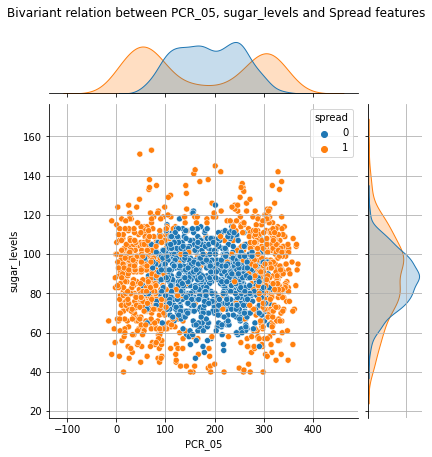

In [ ]:
#Plotting a jointplot for 2 most correlated features
g = sns.jointplot(data = train[['PCR_05', 'sugar_levels', 'spread']], x = 'PCR_05', y = 'sugar_levels', hue = 'spread')
_ = g.ax_joint.grid()
plt.grid()
plt.suptitle("Bivariant relation between PCR_05, sugar_levels and Spread features", y=1.05)

# Part 4: Preparing Data

## Q20

In [ ]:
#Imputing missing values in happiness_score
most_common = train.happiness_score.value_counts().idxmax()
train['happiness_score'].fillna(most_common, inplace = True)

## Q21


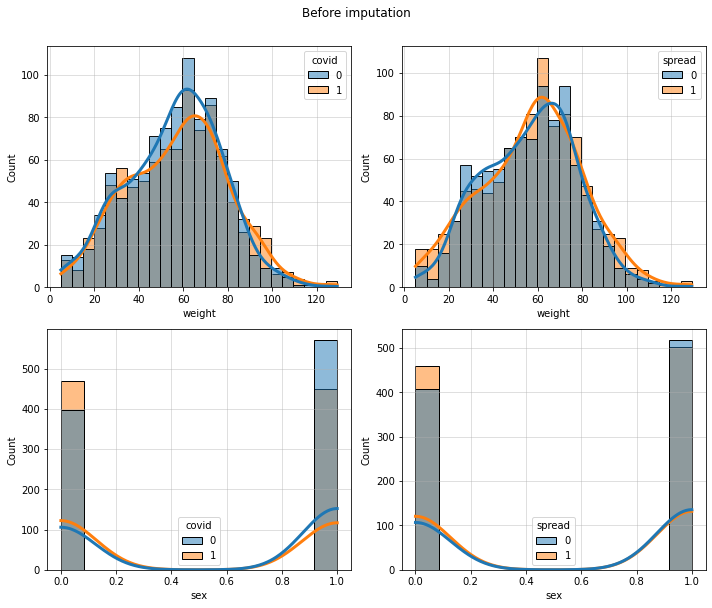

In [ ]:
#Plotting before imputation
COL_NAME = ['weight', 'sex']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 plt.suptitle("Before imputation", y = 1.05)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
              kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
              kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

In [ ]:
#Performing imputation on all features with missing values
cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'conversations_per_day', 'sugar_levels', 'sport_activity', 'PCR_03', 
                                    'pcr_day', 'pcr_month', 'pcr_year']
cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_09', 
                                'current_location_latitude', 'current_location_longitude']

for col in cols_missing_data_non_continuous:
  most_common = train[col].value_counts().idxmax()
  train[col].fillna(most_common, inplace = True)

for col in cols_missing_data_continuous:
  median = train[col].median(skipna = True)
  train[col].fillna(median, inplace = True)

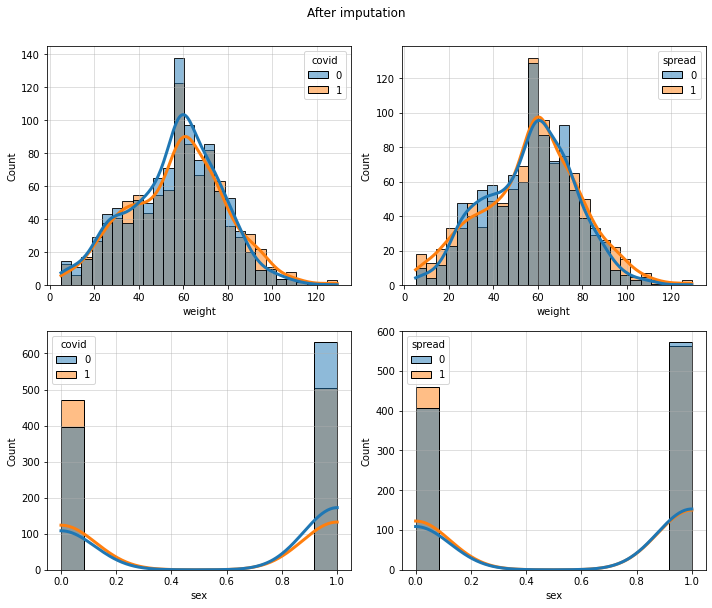

In [ ]:
#Plotting after imputation
COL_NAME = ['weight', 'sex']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 plt.suptitle("After imputation", y = 1.05)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
              kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
              kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

##Q22

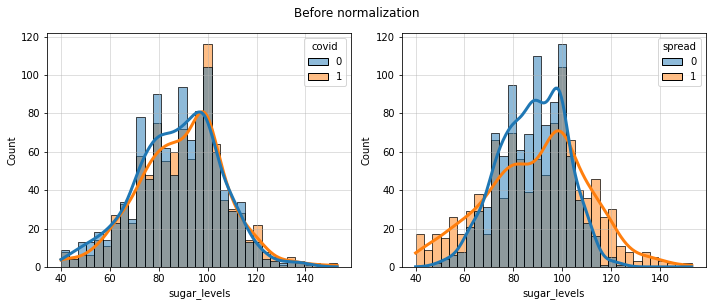

In [ ]:
#Plotting before normalization
COL_NAME = ['sugar_levels']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)

 plt.suptitle("Before normalization", y = 1.05)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

In [ ]:
#Performing normalization on all features

cols_to_minmax = ['sex', 'O+', 'O-', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'num_of_siblings', 'happiness_score', 
                  'conversations_per_day', 'sport_activity', 'PCR_03', 'cough', 'fever', 'low_appetite',
                  'shortness_of_breath', 'sore_throat']

features = train[cols_to_minmax]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

train[cols_to_minmax] = features

cols_to_standard = ['patient_id', 'age', 'weight', 'current_location_latitude', 'current_location_longitude', 
                    'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 
                    'PCR_07', 'PCR_09', 'pcr_day', 'pcr_month', 'pcr_year']
                    
features = train[cols_to_standard]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

train[cols_to_standard] = features

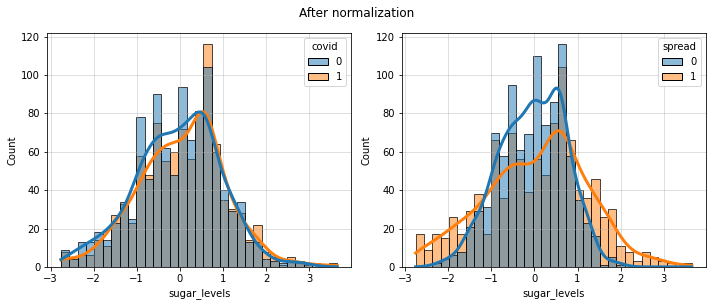

In [ ]:
#Plotting after normalization
COL_NAME = ['sugar_levels']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)

 plt.suptitle("After normalization", y = 1.05)
 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

##Q23

In [ ]:
#Creating temporary dataframe
temp_train = train.filter(like = 'PCR')

In [ ]:
def plot_corr_matrix(df, title):
  corr_matrix = np.abs(df.corr()).round(decimals=3)

  mask = np.zeros_like(corr_matrix, dtype=bool)
  mask[np.triu_indices_from(mask)]= True

  f, ax = plt.subplots(figsize=(15, 20)) 
  heatmap = sns.heatmap(corr_matrix, 
                        mask = mask,
                        square = True,
                        linewidths = .5,
                        cmap = "OrRd",
                        cbar_kws = {'shrink': .6, "ticks" : [0, 0.5, 1]},
                        vmin = 0, 
                        vmax = 1,
                        annot = True,
                        annot_kws = {"size": 12})
  #add the column names as labels
  ax.set_title(title)
  ax.set_yticklabels(corr_matrix.columns, rotation = 0)
  ax.set_xticklabels(corr_matrix.columns)
  sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

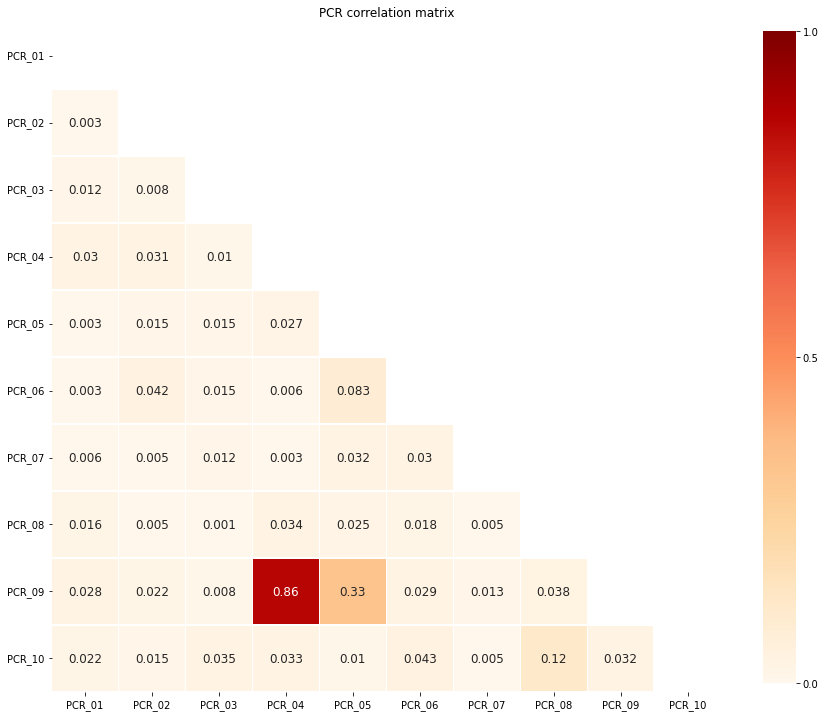

In [ ]:
#Plotting correlation matrix
plot_corr_matrix(temp_train, "PCR correlation matrix")

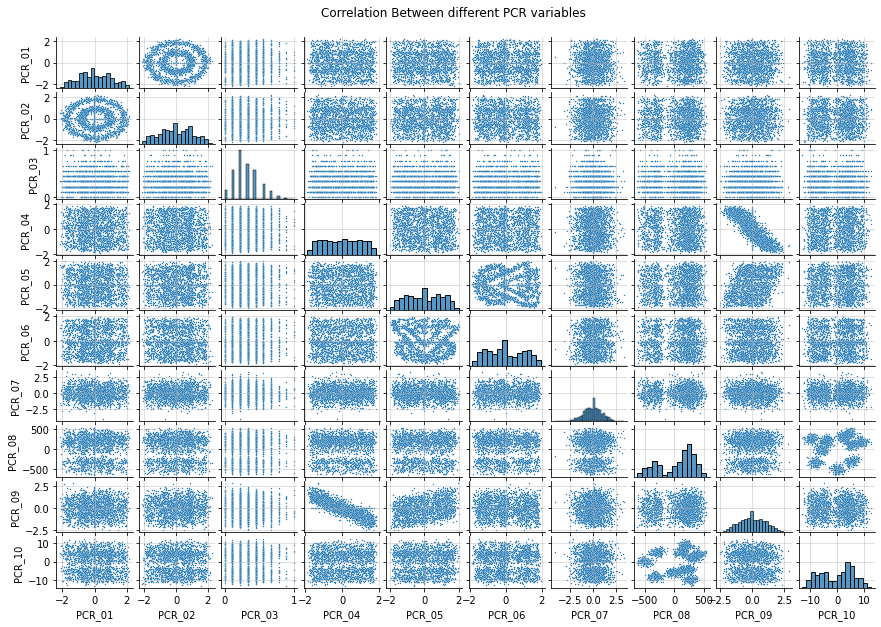

In [ ]:
#Plotting pair plots for all PCR features
g=sns.pairplot(temp_train, plot_kws={"s": 2})
g.fig.suptitle("Correlation Between different PCR variables", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

##Q24

In [ ]:
def plot3d(df, colX, colY, colZ, hue=None):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 5))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=1)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.tight_layout()
  plt.suptitle("3D visualization of the 3 highest correlated PCR features")
  plt.show()

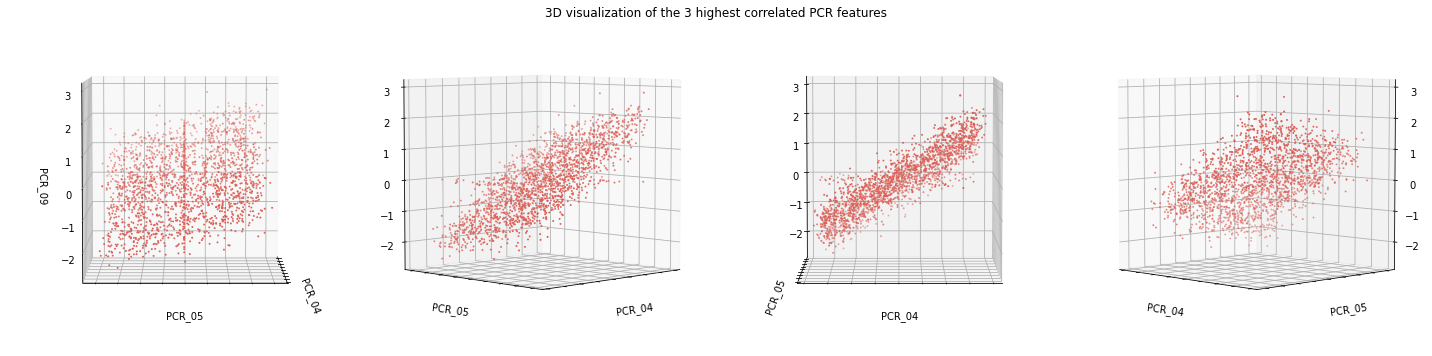

In [ ]:
plot3d(temp_train, 'PCR_04', 'PCR_05', 'PCR_09')

##Q25

In [ ]:
#Using sequential feature selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)

#Disregarding target variables
train_no_target = train.drop('risk', axis = 1 , inplace = False)
train_no_target = train_no_target.drop('spread', axis = 1 , inplace = False)
train_no_target = train_no_target.drop('covid', axis = 1 , inplace = False)

sfs = SequentialFeatureSelector(knn, n_features_to_select = 2).fit(train_no_target, train.spread)
train_no_target.columns[sfs.get_support()]

Index(['sugar_levels', 'PCR_05'], dtype='object')

##Q27

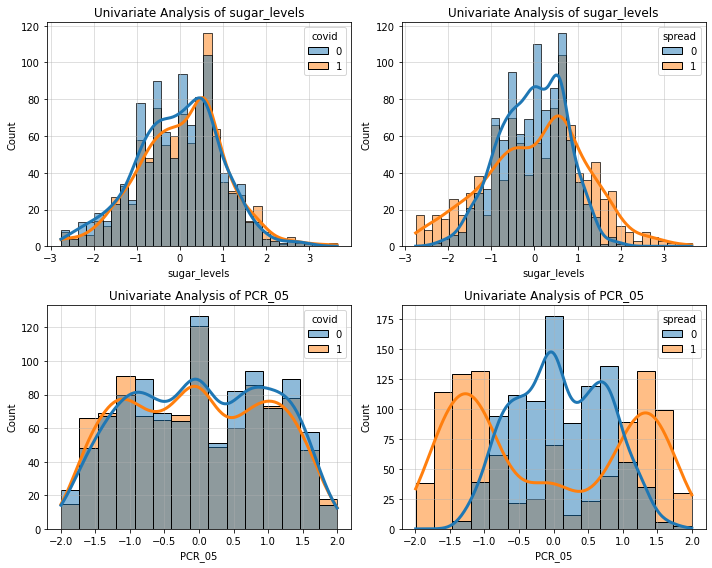

In [ ]:
#Plotting univariate analysis for sugar_levels and PCR_05
COL_NAME = ['sugar_levels', 'PCR_05']
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.title(("Univariate Analysis of " + COL_NAME[row]))
 
 plt.subplot(ROWS,COLS, row * COLS + 2)

 sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
 kde=("float" in train[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.title(("Univariate Analysis of " + COL_NAME[row]))
plt.tight_layout()

In [ ]:
#Calculating correlation between all features and spread
s1 = train.corr().spread.abs()
s1.sort_values(kind="quicksort", ascending=False)

spread                        1.000000
PCR_06                        0.114982
PCR_05                        0.099666
pcr_year                      0.058072
O-                            0.044679
sugar_levels                  0.041966
A+                            0.038875
sex                           0.034129
A-                            0.033299
pcr_month                     0.033160
PCR_10                        0.032669
O+                            0.032305
fever                         0.028397
age                           0.025707
B-                            0.025704
PCR_09                        0.025182
low_appetite                  0.022457
PCR_03                        0.021799
cough                         0.021642
pcr_day                       0.020416
risk                          0.019692
weight                        0.018844
PCR_07                        0.018023
current_location_latitude     0.017370
household_income              0.016705
AB-                      

In [ ]:
#Calculating correlation between all features and covid
s2 = train.corr().covid.abs()
s2.sort_values(kind="quicksort", ascending=False)

covid                         1.000000
sore_throat                   0.676008
shortness_of_breath           0.269202
sport_activity                0.222544
cough                         0.184765
PCR_01                        0.168945
PCR_09                        0.110977
PCR_04                        0.110006
sex                           0.098304
A+                            0.076868
O+                            0.068121
sugar_levels                  0.050317
patient_id                    0.038529
fever                         0.033234
weight                        0.029661
B+                            0.029635
PCR_05                        0.026394
PCR_02                        0.023795
A-                            0.021553
PCR_07                        0.018826
pcr_year                      0.018177
happiness_score               0.017781
B-                            0.016856
conversations_per_day         0.016485
PCR_10                        0.014635
num_of_siblings          

Text(0.5, 1.0, 'Correlation between sore_throat feature and covid target')

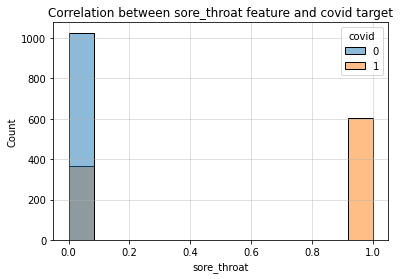

In [ ]:
#Plotting histogram for sore_throat and covid target variable
sns.histplot(data=train, x='sore_throat', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between sore_throat feature and covid target")

In [ ]:
from copy import copy
temp_train = copy(train)
#Number of incorrect results when has sore_throat (patients with sore_throat who dont have covid)
temp_train[((temp_train.sore_throat == 1) & (temp_train.covid == 0))].shape[0]

1

In [ ]:
#Correlations for new data
temp_train.drop(temp_train[temp_train.sore_throat == 1].index, inplace = True)
s2 = temp_train.corr().covid.abs()
s2.sort_values(kind="quicksort", ascending=False)

covid                         1.000000
shortness_of_breath           0.425796
cough                         0.309006
sport_activity                0.300234
PCR_01                        0.264928
PCR_04                        0.161864
O+                            0.148563
PCR_09                        0.144865
A+                            0.143445
sugar_levels                  0.057119
A-                            0.056026
patient_id                    0.049559
weight                        0.045777
current_location_longitude    0.045148
age                           0.037816
pcr_day                       0.033021
PCR_06                        0.029629
low_appetite                  0.027043
PCR_07                        0.027032
pcr_month                     0.024902
num_of_siblings               0.019392
happiness_score               0.018303
PCR_05                        0.018205
risk                          0.017831
AB+                           0.017070
household_income         

Text(0.5, 1.0, 'Correlation between shortness_of_breath feature and covid target, out of patients with no sore_throat symptom')

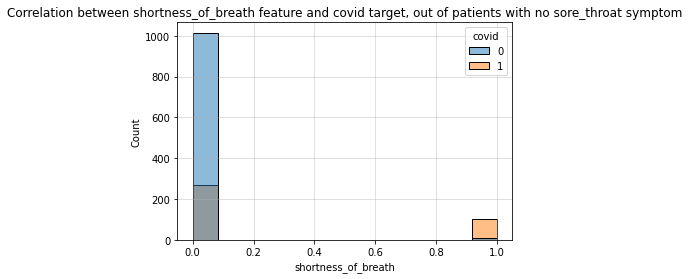

In [ ]:
#Plotting histogram for shortness_of_breath and covid target variable
sns.histplot(data=temp_train, x='shortness_of_breath', hue="covid", line_kws={"linewidth": 3})
plt.grid(alpha = 0.5)
plt.title("Correlation between shortness_of_breath feature and covid target, out of patients with no sore_throat symptom")

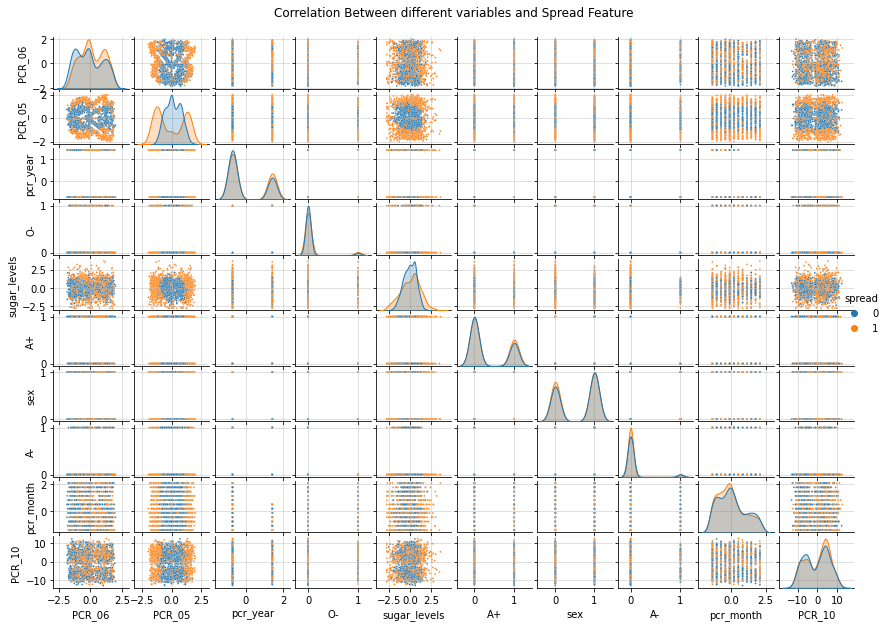

In [ ]:
#Checking correlations for 10 highest correlated features - spread
g=sns.pairplot(train[['PCR_06', 'PCR_05', 'pcr_year', 'O-', 'sugar_levels', 'A+', 'sex', 'A-', 'pcr_month', 'PCR_10', 'spread']], 
               hue = 'spread', plot_kws={"s": 3})
g.fig.suptitle("Correlation Between different variables and Spread Feature", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

Text(0.5, 1.05, 'Bivariant relation between PCR_05, PCR_06 and Spread features')

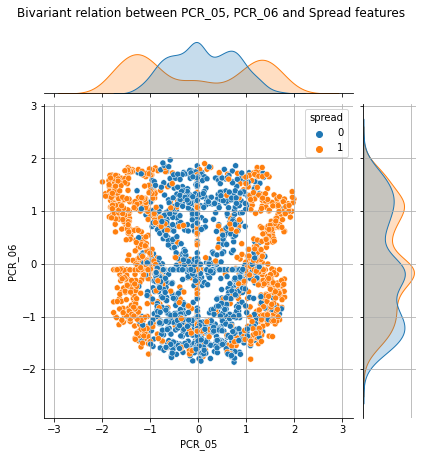

In [ ]:
#Plotting a jointplot for PCR_05 and PCR_06
g = sns.jointplot(data = train[['PCR_05', 'PCR_06', 'spread']], x = 'PCR_05', y = 'PCR_06', hue = 'spread')
_ = g.ax_joint.grid()
plt.grid()
plt.suptitle("Bivariant relation between PCR_05, PCR_06 and Spread features", y=1.05)

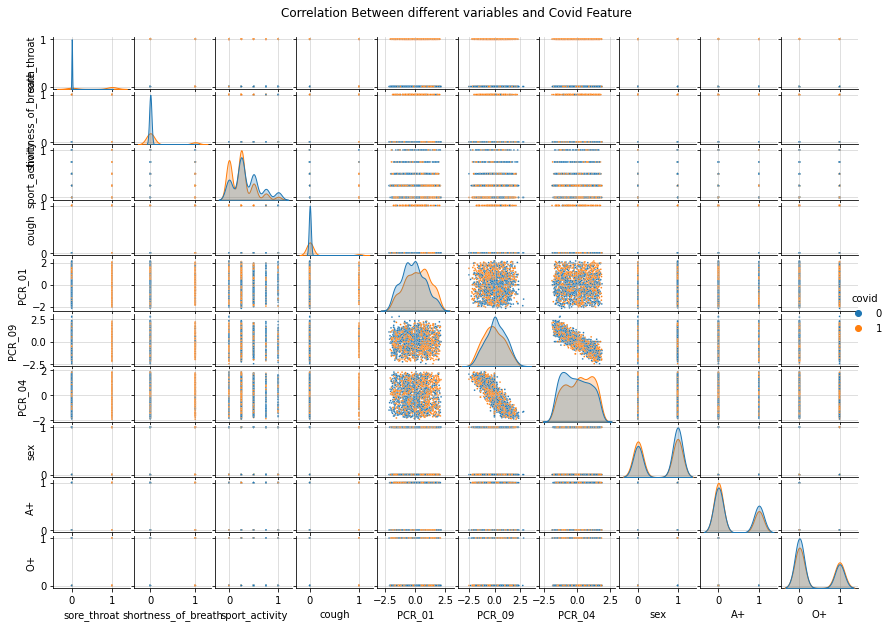

In [ ]:
#Checking correlations for 10 highest correlated features - covid
g=sns.pairplot(train[['sore_throat', 'shortness_of_breath', 'sport_activity', 'cough', 'PCR_01', 'PCR_09',
                      'PCR_04', 'sex', 'A+', 'O+', 'covid']], 
               hue = 'covid', plot_kws={"s": 3})
g.fig.suptitle("Correlation Between different variables and Covid Feature", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

Text(0.5, 1.05, 'Bivariant relation between PCR_01, sore_throat and covid features')

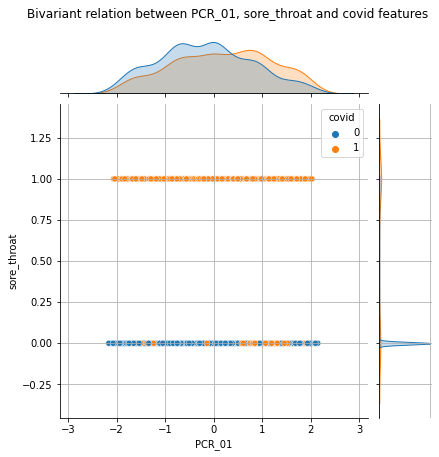

In [ ]:
#Plotting a jointplot for PCR_01 and sore_throat
g = sns.jointplot(data = train[['PCR_01', 'sore_throat', 'covid']], x = 'PCR_01', y = 'sore_throat', hue = 'covid')
_ = g.ax_joint.grid()
plt.grid()
plt.suptitle("Bivariant relation between PCR_01, sore_throat and covid features", y=1.05)

In [ ]:
#Using sequential feature selector for spread
knn = KNeighborsClassifier(n_neighbors = 5)

sfs = SequentialFeatureSelector(knn, n_features_to_select = 3).fit(train_no_target, train.spread)
train_no_target.columns[sfs.get_support()]

Index(['sugar_levels', 'PCR_05', 'low_appetite'], dtype='object')

In [ ]:
#Using sequential feature selector for covid
knn = KNeighborsClassifier(n_neighbors = 5)

sfs = SequentialFeatureSelector(knn, n_features_to_select = 3).fit(train_no_target, train.covid)
train_no_target.columns[sfs.get_support()]

Index(['cough', 'shortness_of_breath', 'sore_throat'], dtype='object')

##Q28

In [ ]:
def prepare_data(data, training_data):
  training_data_copy = training_data  
  training_data_copy = clean_data(training_data_copy)
  training_data_copy, most_comon_l, median_l = data_imputation_training_data(training_data_copy)
  training_data_copy = Data_Normalization(training_data_copy)
  training_data_copy = data_Selection(training_data_copy)

  data_copy = data  
  data_copy = clean_data(data_copy)
  data_copy = data_imputation_test(data_copy, most_comon_l, median_l)
  data_copy = Data_Normalization(data_copy)
  data_copy = data_Selection(data_copy)

  return data_copy

def clean_data(data):
  data.risk = data.risk.replace({'High': 1, 'Low': -1})
  blood_type_one_hot = pd.get_dummies(data['blood_type'])
  data = data.join(blood_type_one_hot)
  data.drop('blood_type' , axis = 1 , inplace = True)
  symptoms_one_hot = data['symptoms'].str.get_dummies(sep=';')
  data = data.join(symptoms_one_hot)
  data.drop('symptoms' , axis = 1 , inplace = True)
  data['sex'].replace({'F': 1, 'M' :0} , inplace = True)
  data['spread'].replace({'High': 1, 'Low' :0}, inplace = True)
  data['covid'].replace({True: 1, False: 0}, inplace = True)
  data[["pcr_day", "pcr_month", "pcr_year"]] = data["pcr_date"].str.split("-", expand = True)
  data.drop('pcr_date' , axis = 1 , inplace = True)
  data['current_location'] = data['current_location'].str.strip("()'")
  data[["current_location_latitude", "current_location_longitude"]] = data["current_location"].str.split("', '", expand = True)
  data.drop('current_location' , axis = 1 , inplace = True)
  data.drop('address' , axis = 1 , inplace = True)

  return data

def data_imputation_training_data(data):
  most_comon_l = []
  median_l = []

  train = data
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', 'conversations_per_day', 'sugar_levels', 'sport_activity', 'PCR_03', 
                                    'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_09', 
                                  'current_location_latitude', 'current_location_longitude']

  for col in cols_missing_data_non_continuous:
    most_common = train[col].value_counts().idxmax()
    most_comon_l.append(most_common)
    train[col].fillna(most_common, inplace = True)

  for col in cols_missing_data_continuous:
    median = train[col].median(skipna = True)
    median_l.append(median)
    train[col].fillna(median, inplace = True)

  return train, most_comon_l, median_l

def data_imputation_test(test, most_comon_l, median_l):
  train = test
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', 'conversations_per_day', 'sugar_levels', 'sport_activity', 'PCR_03', 
                                    'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_09', 
                                  'current_location_latitude', 'current_location_longitude']

  for index, col in enumerate(cols_missing_data_non_continuous):
    train[col].fillna(most_comon_l[index], inplace = True)

  for index, col in enumerate(cols_missing_data_continuous):
    train[col].fillna(median_l[index], inplace = True)

  return train

def Data_Normalization(data):
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler

  train = data
  cols_to_minmax = ['sex', 'O+', 'O-', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'num_of_siblings', 'happiness_score', 
                    'conversations_per_day', 'sport_activity', 'PCR_03', 'cough', 'fever', 'low_appetite',
                    'shortness_of_breath', 'sore_throat']

  features = train[cols_to_minmax]
  scaler = MinMaxScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_minmax] = features

  cols_to_standard = ['patient_id', 'age', 'weight', 'current_location_latitude', 'current_location_longitude', 
                      'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 
                      'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'pcr_day', 'pcr_month', 'pcr_year']
                      
  features = train[cols_to_standard]

  scaler = StandardScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_standard] = features

  return train

def data_Selection(data):
  columns_to_drop = ['patient_id', 'age', 'weight', 'num_of_siblings', 'household_income', 'conversations_per_day', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_07', 'PCR_09', 'AB+', 'AB-', 'B+', 'B-', 'fever', 'pcr_day', 'current_location_latitude', 'current_location_longitude', 'happiness_score', 'happiness_score']
  data = data.drop(columns_to_drop , axis = 1)
  return data





In [ ]:
pd.set_option('display.max_columns', None)
dataset = pd.read_csv(filename)
from sklearn.model_selection import train_test_split
#Splitting the data into 'train' and 'test'
train_df, test_df = train_test_split(dataset, test_size = 0.2, train_size = 0.8, random_state = 122)

In [ ]:
# Clean training set according to itself
train_df_clean = prepare_data(train_df, train_df)
# Clean test set according to the raw training set
test_df_clean = prepare_data(test_df, train_df)

# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>